# Advanced Python for Data Science
### DS-GA-3001.001/.002/.003

### Homework Assignment 04
### Due date: 03/08/2021, 4:00PM
### Student's Name: Yuhan Liu
### Student's e-mail: yl7576@nyu.edu

# Problem 1 (100 points)

The task is to optimize your solutions by using "line_profiler". 

Your submission "spring2021_sol04_yourid.ipynb" will contain:
- the first part is your original solution (a solution that you originally wrote); 
- the second part is your final, optimized solution after using line_profiler; 
- both of which will include the line_profiler results, and your detailed comments.


The problem is to simulate a random motion of $n$ objects over a discrete time. 

Concretely, there is:
- a unit square $[0,1]^2$, 
- $n$ points within the unit square, 
- and the time is discrete $t=0, 1, 2, \dots$. 

At time $t=0$, the positions of $n$ points are randomly and uniformly distributed within the unit square; call these positions $\{p_0, p_1, p_2,\dots, p_{n-1}\}$. 

At every time step $t \geq 0$, every point $i$, chooses to randomly move in one of four directions: left, right, up, down. The distance is also random uniform number on $[0, \delta]$, where $\delta$ is given. 

That is, at every time step $t$ and for every $i$ we generate a random move as: 
$$ p_i := p_i + r_i \cdot u_i$$
where 
$$ r_i \sim uniform[0, \delta],$$ 
and 
$u_i$ represents a random direction, i.e. a randomly chosen vector among $(-1, 0), (1, 0), (0, -1), (0, 1)$.

**Dynamics**

Now, one would like to examine and plot the diagram of the minimum distance $d_{\min}$ among these $n$ points over $T$ iterations.

The task is to complete the rest of this notebook, where definitions of the functions main_orignal and main_optimized are given below. 

In [91]:
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import combinations
import math

In [49]:
%load_ext line_profiler

---

### The original code description: 

In the original code, I first generated n points by using for loop and random.uniform. To get distances between every pair of points, I used combinations and for each pair of points, calculated the distance between them. Finally, in each time t, I moved each point with step size ri and random direction ui in a for loop. Moreover, in order to guarantee all points are in the unit square, I check the position of the updated point. If it is outside the square, the original point will not move. Otherwise, it moved. 

By using line profile (shown below), the total runtime is 105.674s and more than 95% of the time is used in the distance calculation part. That is because all combinations of 1500 points are in the loop, making the function run for 22485020 times and time complexity equal to O(n^2). Also, calculation inside the loop needs lots of time. Therefore, to optimize the funtion, we should mainly try to improve the distance calculation part and avoid large loops.

---


In [123]:
def main_original(n, delta, T): 
    """ 
    n: is the number of uniformly at random generated points in the unit square 
    delta: a maximal move of a point in one of four random directions: left, right, up, or down 
    T: number of iterations
    return: 
    lst_of_min_distances: of the minimum distances among all n points over times: t=0, 1, 2, \dots, T - 1,
    it is a list of reals of length T"""
   
    # generate n points
    all_p = []
    for i in range(n):
        p_ij = (np.random.uniform(0,1), np.random.uniform(0,1))
        all_p.append(p_ij)
    
    # find min distance
    lst_of_min_distances = []
    for t in range(T):
        all_dist = []
        combinations(all_p,2)
        for pair in combinations(all_p,2): # find all pairs of all poins
            p1 = pair[0] # the first point
            p2 = pair[1] # the second point
            dist = ((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)**(0.5)
            all_dist.append(dist)
        lst_of_min_distances.append(min(all_dist))

    # update points
        for i in range(n): # every point
            ri = np.random.uniform(0,delta)
            ui = random.choice([(-1, 0), (1, 0), (0, -1), (0, 1)])
            new_p = np.add(all_p[i],(ui[0]*ri,ui[1]*ri))
            if new_p[0]<1 or new_p[0]>0 or new_p[1]<1 or new_p[1]>0:
                all_p[i] = new_p
    
    return lst_of_min_distances

In [124]:
n = 1500
delta = 1.0 / n
T = 20

In [125]:
%lprun -f main_original lst_min_dist = main_original(n, delta, T)

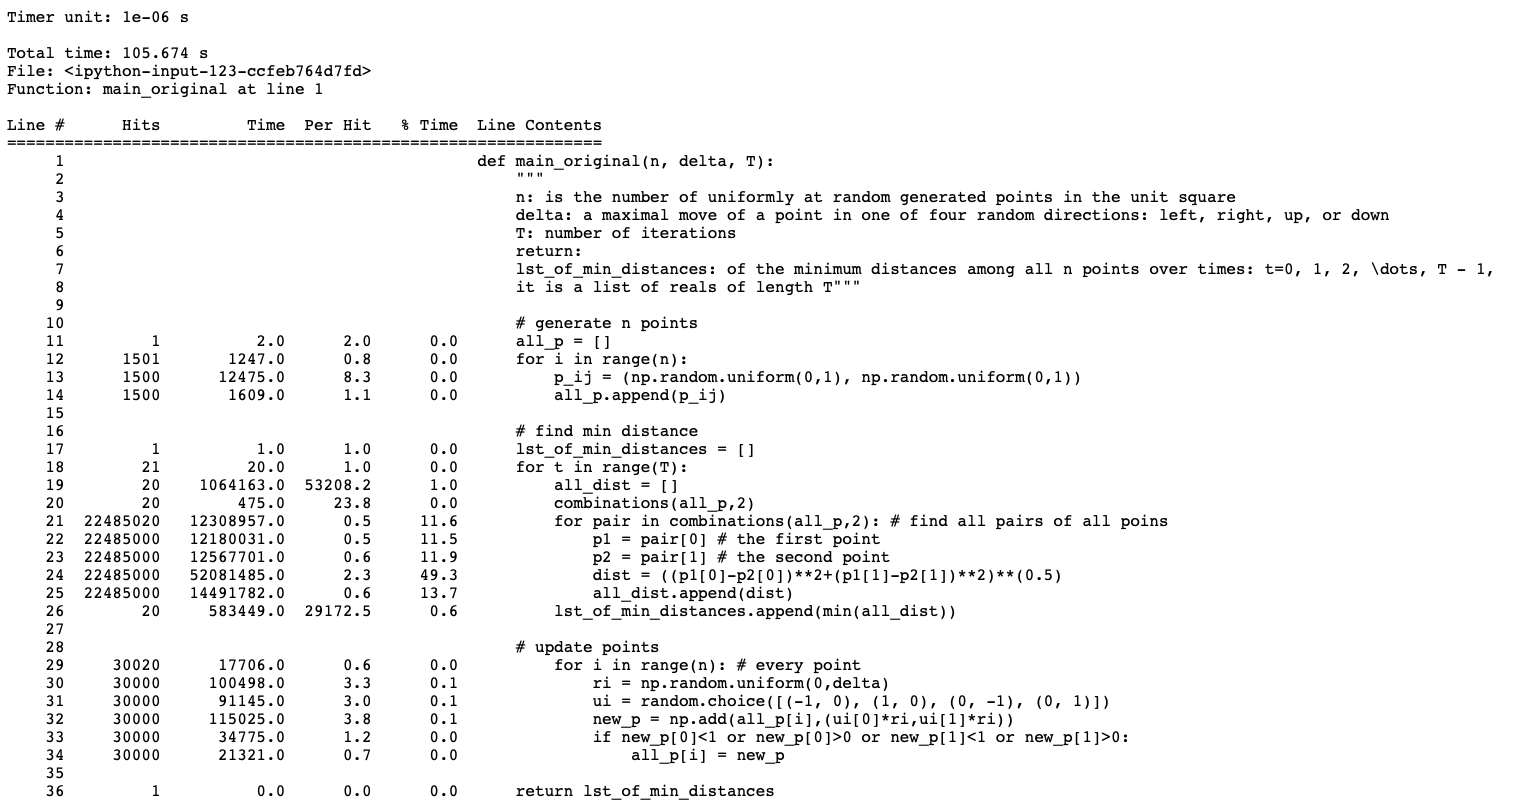

len: 20


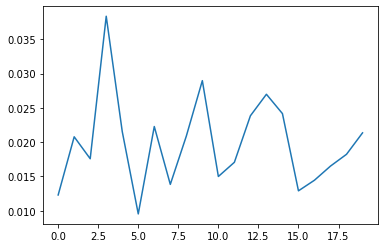

In [126]:
# plot the diagram of the minimum distances:
# where we rescale distance with by factor $\sqrt{n}$:
print("len:", len(lst_min_dist))
plt.plot(range(T), np.array(lst_min_dist) * np.sqrt(n))
plt.show()

---

### The optimized code description: 

In this section, I used divide conquer algorithm to avoid the loop of pairs. This algorithm is modified from Closest pair of points problem, which could speed up the time complexity to O(nlogn). In this way, in my main_optimized function, I can just call divide_conquer(all_p) for each time t. 

After optimizing, the line profiler shows that the total runtime is 2.396s, which is only 2% of the original function. Here, 82.8% of runtime is spent on calling the divide_conquer function and it makes sense because that is where most logic and calculations locate. More importantly, there are only 20 hits in this part instead of 20 million, which speeds up the whole function a lot. In addition, the rest of runtime is used for moving each point. The for loop cannot be avoided here but it does not make significant effect.  

---


In [139]:
def distance(p1, p2):
    return float(math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2))

def merge(l1, l2):
    tot_p = []
    while l1 and l2:
        if(l1[0][1] < l2[0][1]):
            tot_p.append(l1.pop(0))
        else:
            tot_p.append(l2.pop(0))
    if(len(l1) != 0):
        tot_p += l1
    elif(len(l2) != 0):
        tot_p += l2
    return tot_p

def divide_conquer(all_p):
    if (len(all_p) == 2):
        all_p.sort(key=lambda x: x[1])
        return distance(all_p[0], all_p[1])
    elif (len(all_p) == 3):
        all_p.sort(key = lambda x: x[1])
        return min(distance(all_p[0], all_p[1]), distance(all_p[1], all_p[2]), distance(all_p[0], all_p[2]))
    
    med_ind=(int(len(all_p)/2))
    if(len(all_p) % 2 == 0):
        l_pts = all_p[:med_ind]
        r_pts = all_p[med_ind:]
        med_x=(all_p[med_ind-1][0] + all_p[med_ind][0])/2
    elif(len(all_p) % 2 != 0):
        l_pts = all_p[:(med_ind + 1)]
        r_pts = all_p[(med_ind + 1):]
        med_x = all_p[med_ind][0]

    l_min_dist = divide_conquer(l_pts)
    r_min_dist = divide_conquer(r_pts)
    delta = min(l_min_dist, r_min_dist)
    
    tot_p = merge(l_pts, r_pts)

    runway = []
    for pi in tot_p:
        if (pi[0] >= med_x-delta and pi[0] <= med_x+delta):
            runway.append(pi)
    runway_min_dist=2
    for i in range(0,len(runway)):
        for j in range(i + 1, min(len(runway), i + 16)):
            runway_min_dist = min(runway_min_dist, distance(runway[i], runway[j]))
    return min(l_min_dist, r_min_dist, runway_min_dist)

In [140]:
def main_optimized(n, delta, T): 
    # generate n points
    all_p = []
    for i in range(n):
        p = (np.random.uniform(0,1), np.random.uniform(0,1))
        all_p.append(p)
        
    # find min distance
    lst_of_min_distances = []
    for t in range(T):
        all_p.sort(key=lambda x: x[0])
        lst_of_min_distances.append(divide_conquer(all_p)) 
        
    # update points                             
        for i in range(n): # every point
            ri = np.random.uniform(0,delta)
            ui = random.choice([(-1, 0), (1, 0), (0, -1), (0, 1)])
            new_p = np.add(all_p[i],(ui[0]*ri,ui[1]*ri))
            if new_p[0]<1 or new_p[0]>0 or new_p[1]<1 or new_p[1]>0:
                all_p[i] = new_p
    return lst_of_min_distances

In [141]:
n = 1500
delta = 1.0 / n
T = 20

In [142]:
%lprun -f main_optimized lst_min_dist = main_optimized(n, delta, T)

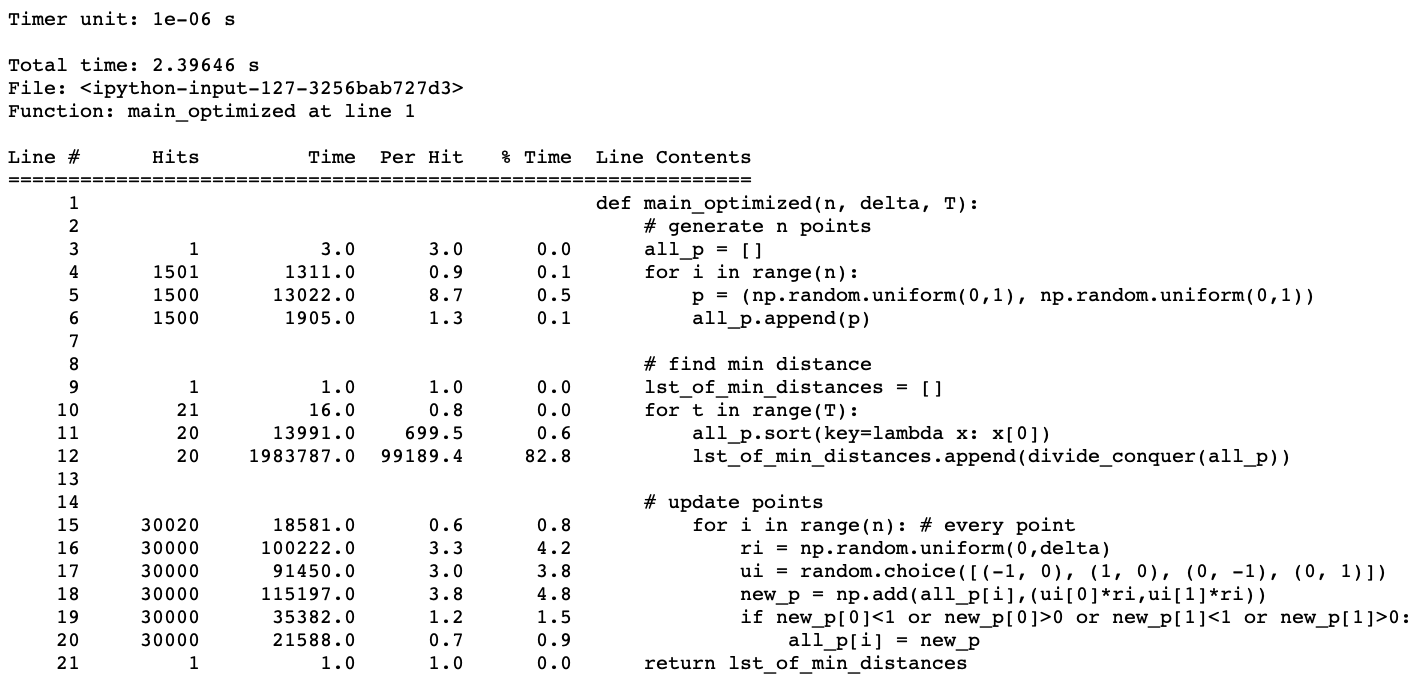

len: 20


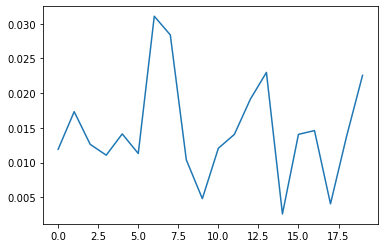

In [143]:
# plot the diagram of the minimum distances:
# where we rescale distance by a factor $\sqrt{n}$:
print("len:", len(lst_min_dist))
plt.plot(range(T), np.array(lst_min_dist) * np.sqrt(n))
plt.show()